# Feature engineering applied to a forecastable time series

The financial time series dataset that I've been considering are difficult to forecast on because they are quite random. This randomness can hide the benefit offered by the various feature engineering approaches. So to illustrate the benefit of various approaches lets consider something easier to forecast, and if necessary introduce some problems to test.

In [1]:
# import my modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2, invert_scaling,inverted_conclusion
from walkforward_validation import walk_forward_val, series_to_supervised
from spectral_denoising import automatic_fourier_denoising, automatic_fourier_denoising_wf, automatic_wavelet_denoising, automatic_wavelet_denoising_wf

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

from tabulate import tabulate

2022-06-30 12:53:28.334332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 12:53:28.334418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# create some noisy, but easy to forecast data

In [2]:
df = pd.read_csv('./test_data/AirPassengers.csv')
df

Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]

In [3]:
random.gauss(-8.1,8.1)

5.355370604059873

/tmp/ipykernel_34408/3236982291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['random_pertubation'].iloc[i] = random.gauss(-df['#Passengers_std'].iloc[i],df['#Passengers_std'].iloc[i])# * random.choice([1,-1])


Month  #Passengers  #Passengers_std  random_pertubation       noisy
0   1949-01          112              NaN            0.000000  112.000000
1   1949-02          118              NaN            0.000000  118.000000
2   1949-03          132              NaN            0.000000  132.000000
3   1949-04          129              NaN            0.000000  129.000000
4   1949-05          121         8.142481           -4.171398  116.828602
5   1949-06          135         7.245688            6.054174  141.054174
6   1949-07          148         9.874209          -11.932496  136.067504
7   1949-08          148        11.861703          -19.610663  128.389337
8   1949-09          136        11.193748            0.717521  136.717521
9   1949-10          119        11.945711           -8.726563  110.273437
10  1949-11          104        19.209373            6.059237  110.059237
11  1949-12          118        17.146428           18.202992  136.202992
12  1950-01          115        11.502174          -24.477987   90.522013
13  1950-02          126         8.018728          -22.822396  103.177604
14  1950-03          141        13.773162          -19.264369  121.735631
15  1950-04          135        11.022704            1.050242  136.050242
16  1950-05          125         9.989995          -17.662452  107.337548
17  1950-06          149        10.158740           -7.950755  141.049245
18  1950-07          170        16.970563          -11.443016  158.556984
19  1950-08          170        20.315019          -23.033129  146.966871
20  1950-09          158        18.662797          -44.554953  113.445047
21  1950-10          133        15.604487          -35.069784   97.930216
22  1950-11          114        24.718414           28.297129  142.297129
23  1950-12          140        21.817424          -21.222735  118.777265
24  1951-01          145        16.232683          -32.081583  112.918417
25  1951-02          150        14.010710          -24.180521  125.819479
26  1951-03          178        22.908514          -37.887951  140.112049
27  1951-04          163        15.352524           18.775573  181.775573
28  1951-05          172        14.046352           -6.060663  165.939337
29  1951-06          178        11.882761           -7.671978  170.328022
30  1951-07          199        13.247641          -11.954086  187.045914
31  1951-08          199        16.238842          -11.565622  187.434378
32  1951-09          184        12.259690          -23.159377  160.840623
33  1951-10          162        15.565989          -12.425215  149.574785
34  1951-11          146        23.441416           -9.160749  136.839251
35  1951-12          166        20.513410          -22.175493  143.824507
36  1952-01          171        13.827509          -19.912988  151.087012
37  1952-02          180        12.569805           -9.317575  170.682425
38  1952-03          193        17.426991            1.175335  194.175335
39  1952-04          181        10.377861           -8.967897  172.032103
40  1952-05          183         7.861298          -12.287882  170.712118
41  1952-06          218        15.953056          -36.193418  181.806582
42  1952-07          230        21.897488           -4.651333  225.348667
43  1952-08          242        27.635123          -52.182121  189.817879
44  1952-09          209        22.434349          -13.662851  195.337149
45  1952-10          191        19.557607          -12.436998  178.563002
46  1952-11          172        28.384855           29.470268  201.470268
47  1952-12          194        26.140008          -56.275389  137.724611
48  1953-01          196        13.315405           -5.648942  190.351058
49  1953-02          196        10.158740            0.058405  196.058405

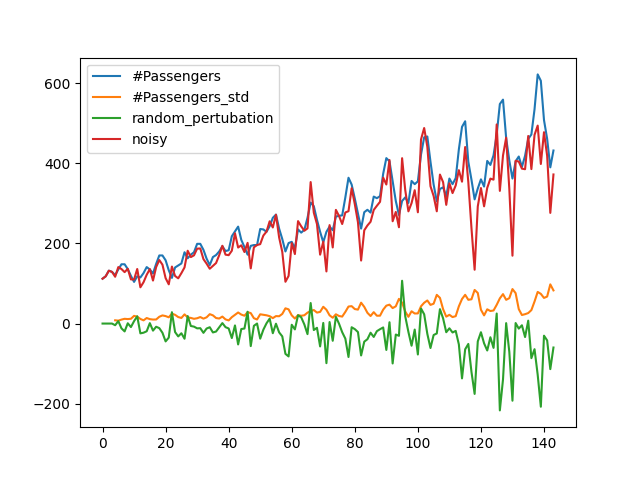

In [4]:
# add some random noise, but do this in proportion to the local stddev
amp = 20
df['#Passengers_std'] = df['#Passengers'].rolling(5).std()
df['random_pertubation'] = 0
for i in range (4,144):
    df['random_pertubation'].iloc[i] = random.gauss(-df['#Passengers_std'].iloc[i],df['#Passengers_std'].iloc[i])# * random.choice([1,-1])
df['noisy'] = df['#Passengers'] + df['random_pertubation'] 

df.plot()
display(df.head(50))

/home/tristan/my_venvs/meng_data/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng_data/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng_data/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


array([112.        , 118.        , 132.        , 129.        ,
       116.82860185, 141.0541739 , 136.06750384, 128.38933689,
       136.71752144, 110.27343657, 101.06583341, 143.97447733,
        72.0938408 ,  66.57255143,  98.34267728, 120.76992497,
       136.06615503, 167.43156554, 133.83574432, 142.07982972,
       133.5582862 ,  92.74755927, 106.94269387, 148.42708338,
       128.10888019, 129.02999913, 162.75967211, 168.48489856,
       185.1046733 , 187.58829637, 182.03279721, 177.55216753,
       161.54636453, 104.84569361, 120.60797048, 147.99891087,
       166.98476443, 160.44812998, 184.78956773, 170.12632895,
       176.70435451, 173.45742455, 219.81218317, 229.79780252,
       224.79186161, 160.50868229, 155.21541807, 165.88731696,
       211.89720526, 204.79961094, 234.79010902, 219.28434501,
       205.65119986, 194.34945122, 255.98858612, 253.13942819,
       236.3019713 , 156.78385784, 113.04710656, 116.92167209,
       179.2611428 , 186.65303963, 246.34029732, 266.12

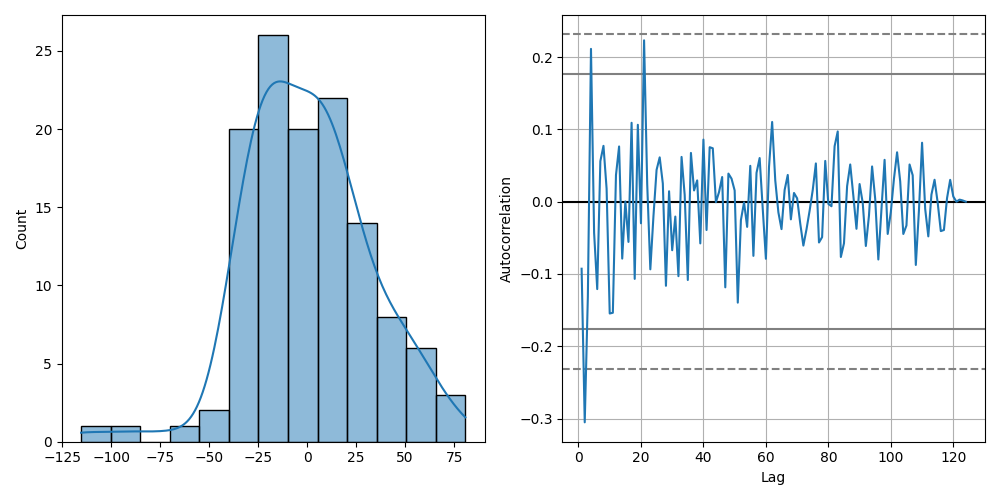

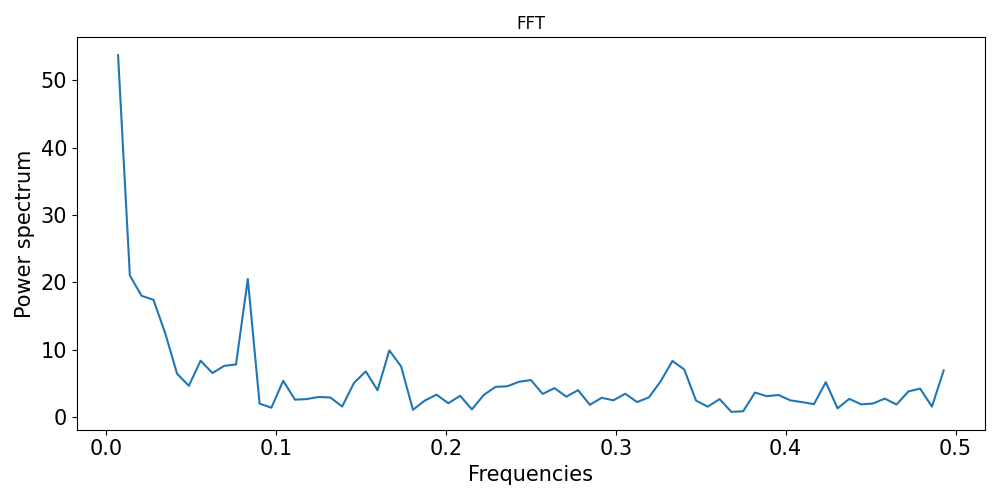

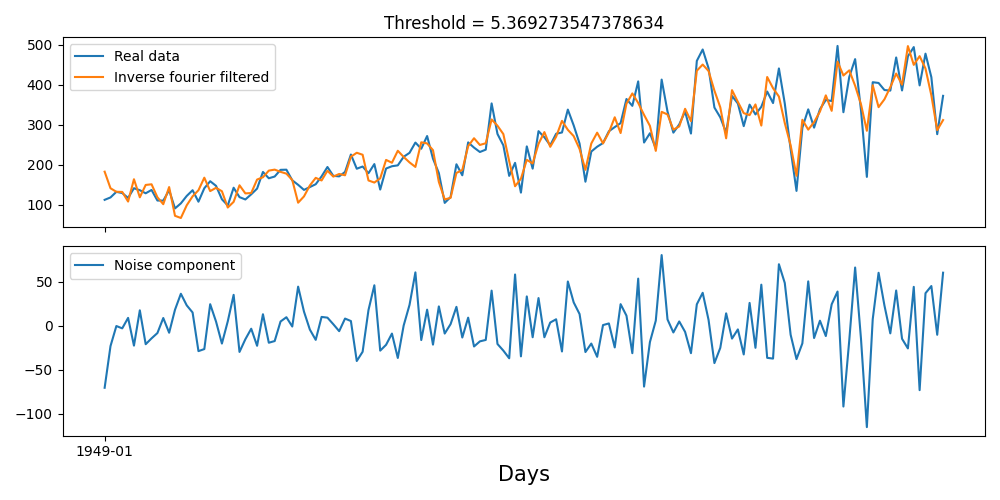

In [5]:
df['Date'] = df['Month']
denoised_signal = automatic_fourier_denoising(df['noisy'].to_numpy(),df['Date'],verbose=True)
denoised_signal

/tmp/ipykernel_34408/2821676088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['denoised_signal'].iloc[0] = df['#Passengers'].iloc[0]


<AxesSubplot:>

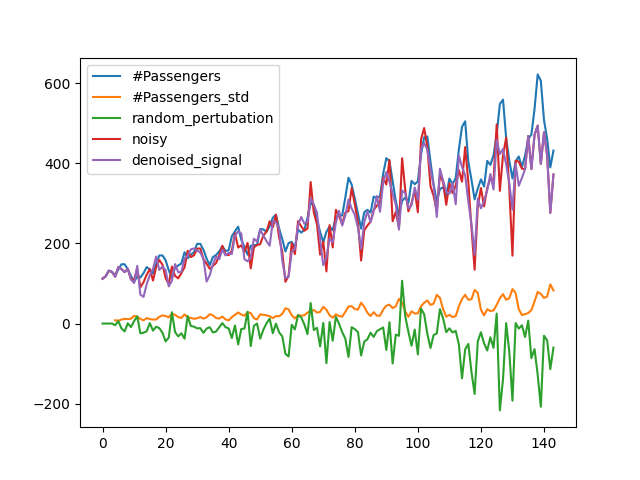

In [6]:
df['denoised_signal'] = 0
df['denoised_signal'].iloc[0] = df['#Passengers'].iloc[0]
df['denoised_signal'] = denoised_signal
df.plot()

# airplane forecast on denoised dataset

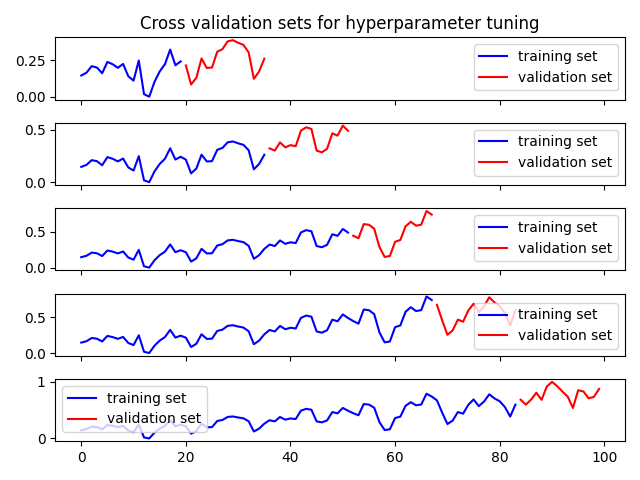

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.36972341 -0.38467634  0.0310449  -0.16855782  0.77530167 -0.25055738
 -0.38634995  0.92889169 -1.16635717  1.03632527 -0.63704904  0.19157304
  0.03515414 -0.5389212   1.20170508]
MAPE: 0.1347512873146673
RMSE:  0.17687409093185028
MAE:  0.14498549625913085

Training support vector machine:
Model params:  {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 0.07196891870655225
RMSE:  0.09375200227354533
MAE:  0.07744930903702353

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nest

2022-06-30 12:53:33.378892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 12:53:33.378925: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 12:53:33.378947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tristan-HP-EliteBook-855-G8-Notebook-PC): /proc/driver/nvidia/version does not exist
2022-06-30 12:53:33.379478: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2000
2/2 [==============================] - 3s 498ms/step - loss: 0.2270 - val_loss: 0.4999
Epoch 2/2000
2/2 [==============================] - 0s 93ms/step - loss: 0.1855 - val_loss: 0.3736
Epoch 3/2000
2/2 [==============================] - 0s 116ms/step - loss: 0.1311 - val_loss: 0.2026
Epoch 4/2000
2/2 [==============================] - 0s 64ms/step - loss: 0.0691 - val_loss: 0.0286
Epoch 5/2000
2/2 [==============================] - 0s 62ms/step - loss: 0.0262 - val_loss: 0.0502
Epoch 6/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.0451 - val_loss: 0.0159
Epoch 7/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.0247 - val_loss: 0.0302
Epoch 8/2000
2/2 [==============================] - 0s 68ms/step - loss: 0.0210 - val_loss: 0.0625
Epoch 9/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.0275 - val_loss: 0.0729
Epoch 10/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.0297 - val_loss: 0.0609
Epoch 1

/tmp/ipykernel_34408/2759656294.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/2759656294.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/2759656294.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Movement prediction accuracy: 45.45 %
Confusion matrix:
[[ 8 11]
 [13 12]]
Movement prediction accuracy: 70.45 %
Confusion matrix:
[[14  5]
 [ 8 17]]
Movement prediction accuracy: 59.09 %
Confusion matrix:
[[12  7]
 [11 14]]
Movement prediction accuracy: 68.18 %
Confusion matrix:
[[12  7]
 [ 7 18]]
+----+-------------------+---------+---------+-----------+----------+
|    | model             |    RMSE |     MAE |      MAPE |       DA |
|----+-------------------+---------+---------+-----------+----------|
|  0 | Linear Regression | 55.1218 | 45.1839 | 0.111974  | 0.454545 |
|  1 | SVM               | 29.2173 | 24.1366 | 0.0597926 | 0.704545 |
|  2 | MLP               | 32.1133 | 26.6981 | 0.0671596 | 0.590909 |
|  3 | LSTM              | 59.8795 | 48.2402 | 0.114575  | 0.681818 |
+----+-------------------+---------+---------+-----------+----------+


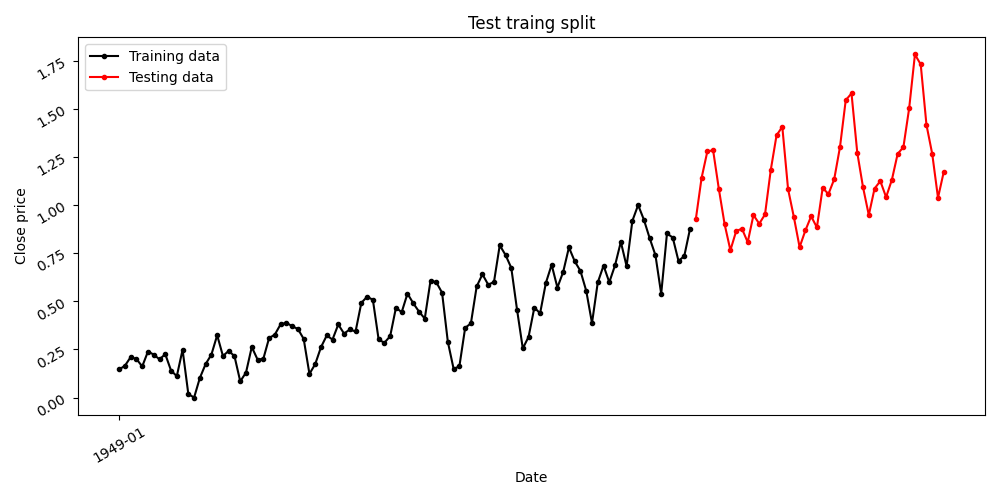

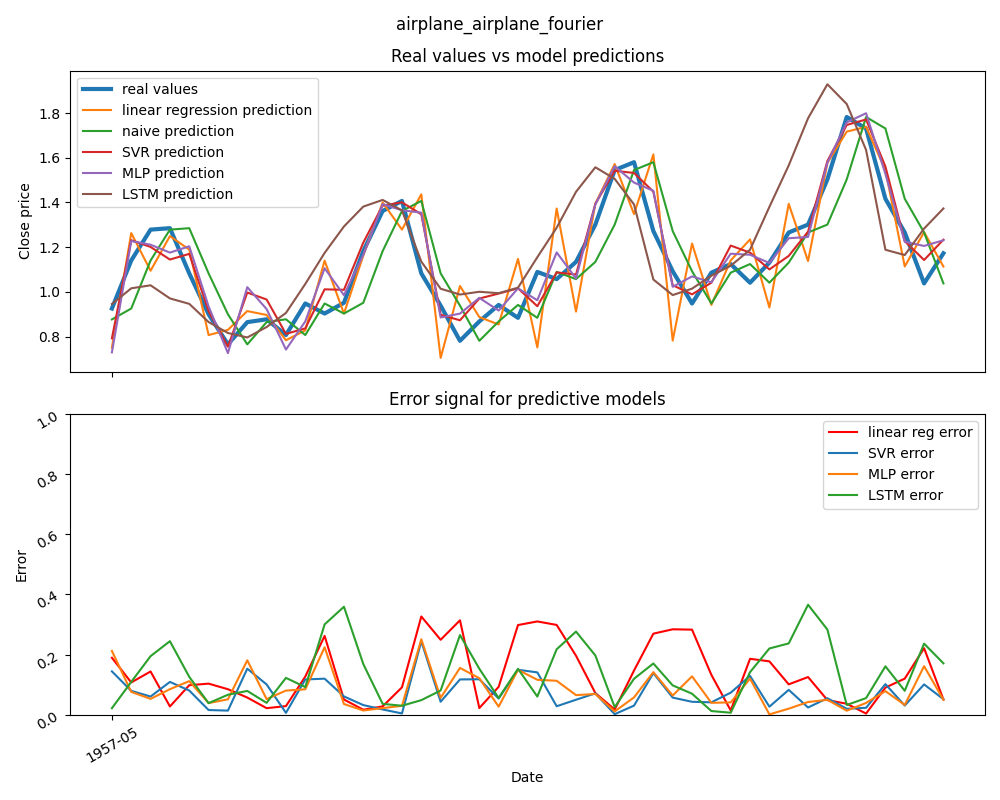

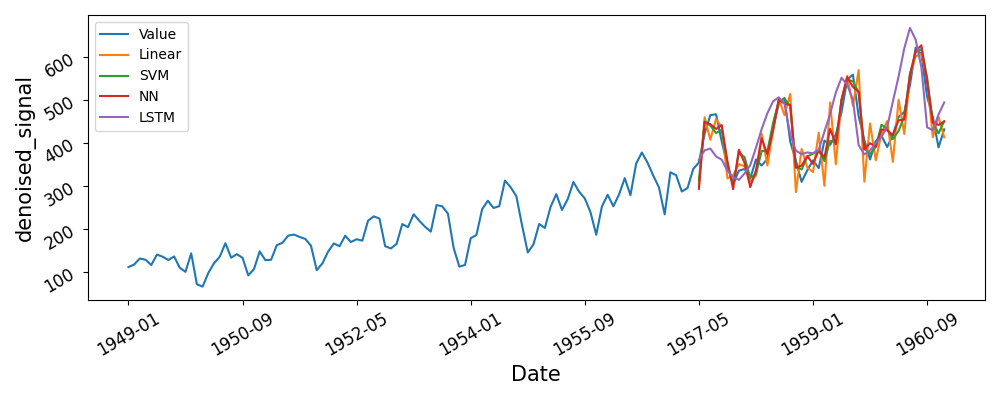

In [7]:
window_length = 15
split = 44 
column_to_predict = 'denoised_signal'
financial_asset = 'airplane'
feat_engineering = 'airplane_fourier'

###################################################################################################
# feature engineering
###################################################################################################

denoised_signal = df['denoised_signal'].to_numpy()
denoised_signal[-split:] = df['#Passengers'].iloc[-split:] # add this so we test against original data

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(denoised_signal[:-split].reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(denoised_signal[-split:].reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=False,C= 10, kernel= 'linear',epsilon=0.1)
blah.neural_net_mlp(model_tunning=False,
                    activation= 'relu', 
                    hidden_layer_sizes= (1000,), 
                    learning_rate= 'invscaling', 
                    learning_rate_init= 0.01,
                    solver='adam')
blah.lstm(model_tunning=False, n_nodes=[128,128,128], n_lstm_layers=3, n_epochs=2000, n_batch=64,verbose=1)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

###################################################################################################
# invert feature engineering (if possible)
###################################################################################################

# invert scaling
inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

# collect inverted results

df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
df_inverted_results['Date'] = df['Date']
df_inverted_results['Value'] = df[f'{column_to_predict}']
df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

# plot invert results
ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
ax.set_xlabel(xlabel='Date',fontsize=15)
ax.tick_params(rotation=30, labelsize=12)    
plt.tight_layout()
plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

# store results
inverted_conclusion(dates=df['Date'].iloc[-split:],
                    original_values=df[f'{column_to_predict}'].iloc[-split:], 
                    linear_preds=inverted_predictions_linear, 
                    svm_pred=inverted_predictions_svm, 
                    nn_preds=inverted_predictions_nn, 
                    lstm_preds=inverted_predictions_lstm,
                    financial_asset=financial_asset,
                    feat_engineer=feat_engineering)

# airplane forecast on noisy data

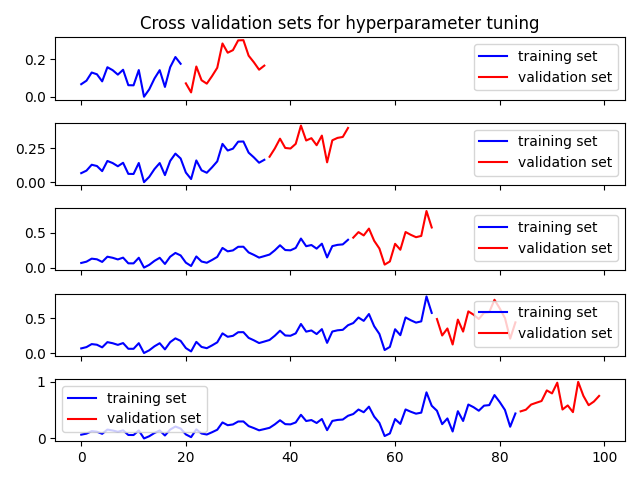

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.39770281  0.14900547 -0.23268884  0.09066721 -0.05032937 -0.03462185
  0.2929412  -0.29623971  0.24756324  0.46710118]
MAPE: 0.12214219514739705
RMSE:  0.150485544816881
MAE:  0.1230196378676459

Training support vector machine:
Model params:  {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 0.13795781206952668
RMSE:  0.16508773590220194
MAE:  0.1357091547046433

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuff

/tmp/ipykernel_34408/4252855998.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/4252855998.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/4252855998.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Movement prediction accuracy: 47.73 %
Confusion matrix:
[[11  8]
 [15 10]]
Movement prediction accuracy: 59.09 %
Confusion matrix:
[[14  5]
 [13 12]]
Movement prediction accuracy: 68.18 %
Confusion matrix:
[[11  8]
 [ 6 19]]
Movement prediction accuracy: 45.45 %
Confusion matrix:
[[ 7 12]
 [12 13]]
+----+-------------------+----------+---------+-----------+----------+
|    | model             |     RMSE |     MAE |      MAPE |       DA |
|----+-------------------+----------+---------+-----------+----------|
|  0 | Linear Regression |  48.5028 | 39.6503 | 0.0945038 | 0.477273 |
|  1 | SVM               |  53.2093 | 43.7403 | 0.106208  | 0.590909 |
|  2 | MLP               |  47.3525 | 37.2609 | 0.0894946 | 0.681818 |
|  3 | LSTM              | 102.21   | 77.4161 | 0.169328  | 0.454545 |
+----+-------------------+----------+---------+-----------+----------+


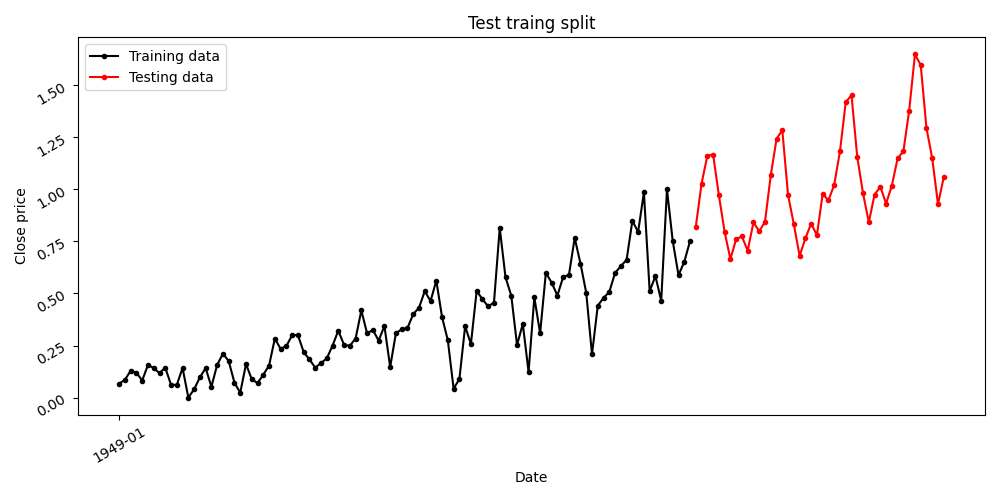

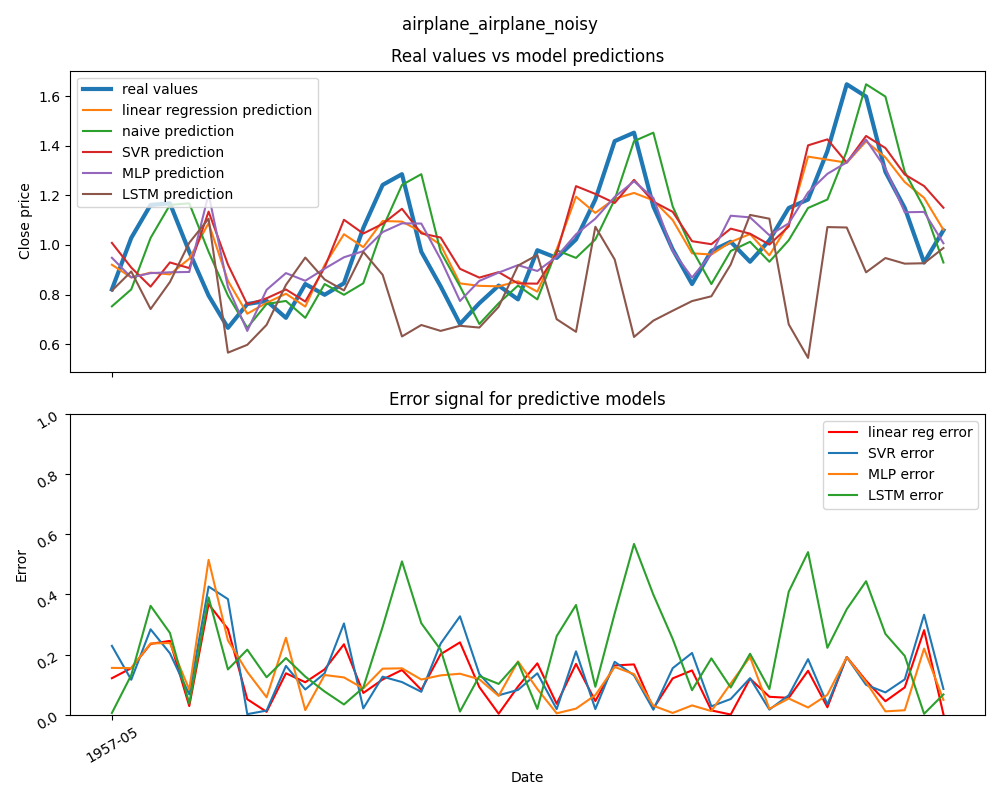

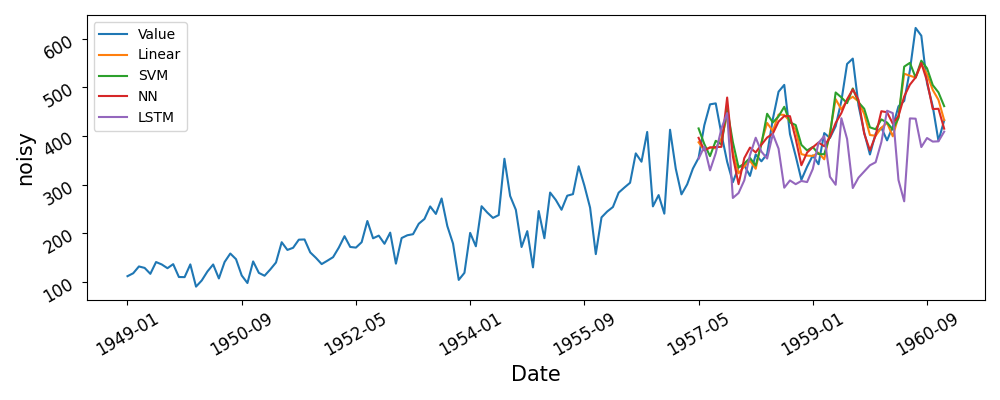

In [8]:
window_length = 15
split = 44 
column_to_predict = 'noisy'
financial_asset = 'airplane'
feat_engineering = 'airplane_noisy'

###################################################################################################
# feature engineering
###################################################################################################

denoised_signal = df['noisy'].to_numpy()
denoised_signal[-split:] = df['#Passengers'].iloc[-split:] # add this so we test against original data


###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(denoised_signal[:-split].reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(denoised_signal[-split:].reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=False,C= 10, kernel= 'linear',epsilon=0.1)
blah.neural_net_mlp(model_tunning=False,
                    activation= 'relu', 
                    hidden_layer_sizes= (1000,), 
                    learning_rate= 'invscaling', 
                    learning_rate_init= 0.01,
                    solver='adam')
blah.lstm(model_tunning=False, n_nodes=[128,128,128], n_lstm_layers=3, n_epochs=2000, n_batch=64,verbose=1)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

###################################################################################################
# invert feature engineering (if possible)
###################################################################################################

# invert scaling
inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

# collect inverted results

df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
df_inverted_results['Date'] = df['Date']
df_inverted_results['Value'] = df[f'{column_to_predict}']
df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

# plot invert results
ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
ax.set_xlabel(xlabel='Date',fontsize=15)
ax.tick_params(rotation=30, labelsize=12)    
plt.tight_layout()
plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

# store results
inverted_conclusion(dates=df['Date'].iloc[-split:],
                    original_values=df[f'{column_to_predict}'].iloc[-split:], 
                    linear_preds=inverted_predictions_linear, 
                    svm_pred=inverted_predictions_svm, 
                    nn_preds=inverted_predictions_nn, 
                    lstm_preds=inverted_predictions_lstm,
                    financial_asset=financial_asset,
                    feat_engineer=feat_engineering)

In [9]:
df

Month  #Passengers  #Passengers_std  random_pertubation       noisy  \
0    1949-01          112              NaN            0.000000  112.000000   
1    1949-02          118              NaN            0.000000  118.000000   
2    1949-03          132              NaN            0.000000  132.000000   
3    1949-04          129              NaN            0.000000  129.000000   
4    1949-05          121         8.142481           -4.171398  116.828602   
..       ...          ...              ...                 ...         ...   
139  1960-08          606        74.106005         -207.663990  606.000000   
140  1960-09          508        63.998437          -30.276519  508.000000   
141  1960-10          461        67.389168          -42.103919  461.000000   
142  1960-11          390        97.840687         -113.752636  390.000000   
143  1960-12          432        82.799758          -59.813624  432.000000   

        Date  denoised_signal  
0    1949-01       112.000000  
1    1949-02       118.000000  
2    1949-03       132.000000  
3    1949-04       129.000000  
4    1949-05       116.828602  
..       ...              ...  
139  1960-08       606.000000  
140  1960-09       508.000000  
141  1960-10       461.000000  
142  1960-11       390.000000  
143  1960-12       432.000000  

[144 rows x 7 columns]

# airplane normal

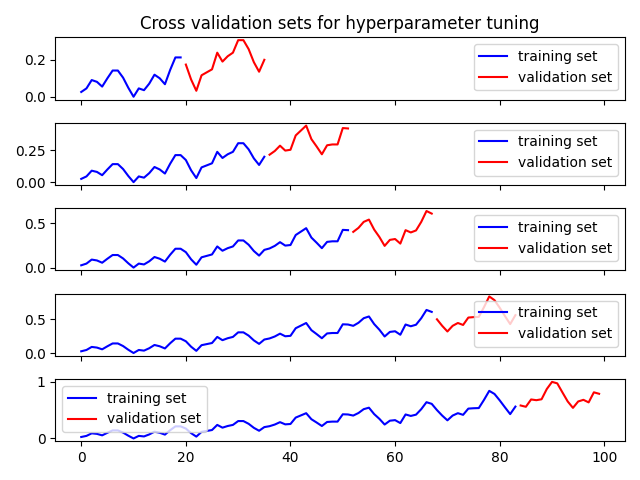

Training multivariate linear regression:

Linear regression coefficients: 
 [ 0.26245242  0.23664824 -0.26829991  0.00620417 -0.04945328  0.4074308
 -0.48738919  0.24371001 -0.30821118  0.97684221]
MAPE: 0.09909704791453938
RMSE:  0.11426782218459043
MAE:  0.10011677039765293

Training support vector machine:
Model params:  {'C': 10, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 0.1063127502293994
RMSE:  0.1177737038319104
MAE:  0.10408888927144765

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (1000,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuf

/tmp/ipykernel_34408/96933344.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/96933344.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/96933344.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

Movement prediction accuracy: 75.0 %
Confusion matrix:
[[16  3]
 [ 8 17]]
Movement prediction accuracy: 75.0 %
Confusion matrix:
[[16  3]
 [ 8 17]]
Movement prediction accuracy: 81.82 %
Confusion matrix:
[[16  3]
 [ 5 20]]
Movement prediction accuracy: 68.18 %
Confusion matrix:
[[13  6]
 [ 8 17]]
+----+-------------------+----------+---------+-----------+----------+
|    | model             |     RMSE |     MAE |      MAPE |       DA |
|----+-------------------+----------+---------+-----------+----------|
|  0 | Linear Regression |  35.3088 | 30.9361 | 0.0735429 | 0.75     |
|  1 | SVM               |  36.3921 | 32.1635 | 0.0782918 | 0.75     |
|  2 | MLP               |  29.3494 | 25.333  | 0.0599885 | 0.818182 |
|  3 | LSTM              | 130.284  | 99.9951 | 0.231603  | 0.681818 |
+----+-------------------+----------+---------+-----------+----------+


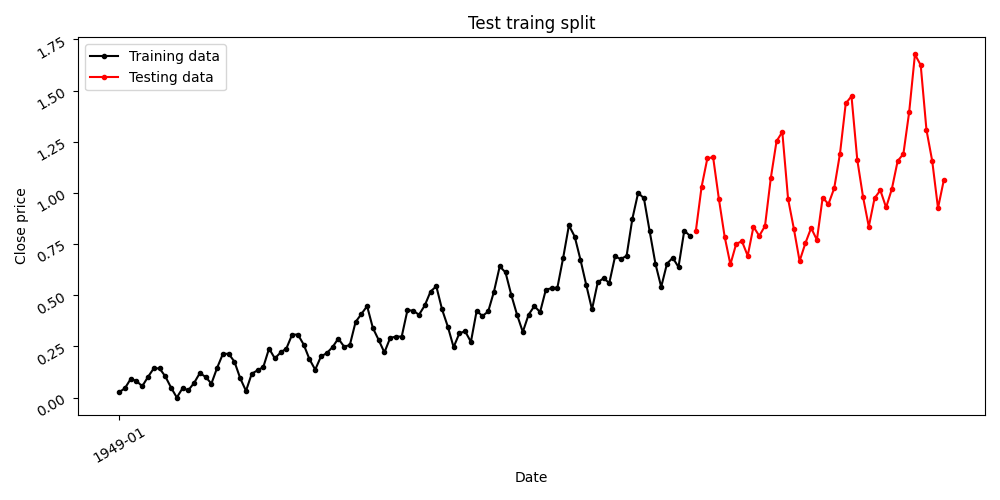

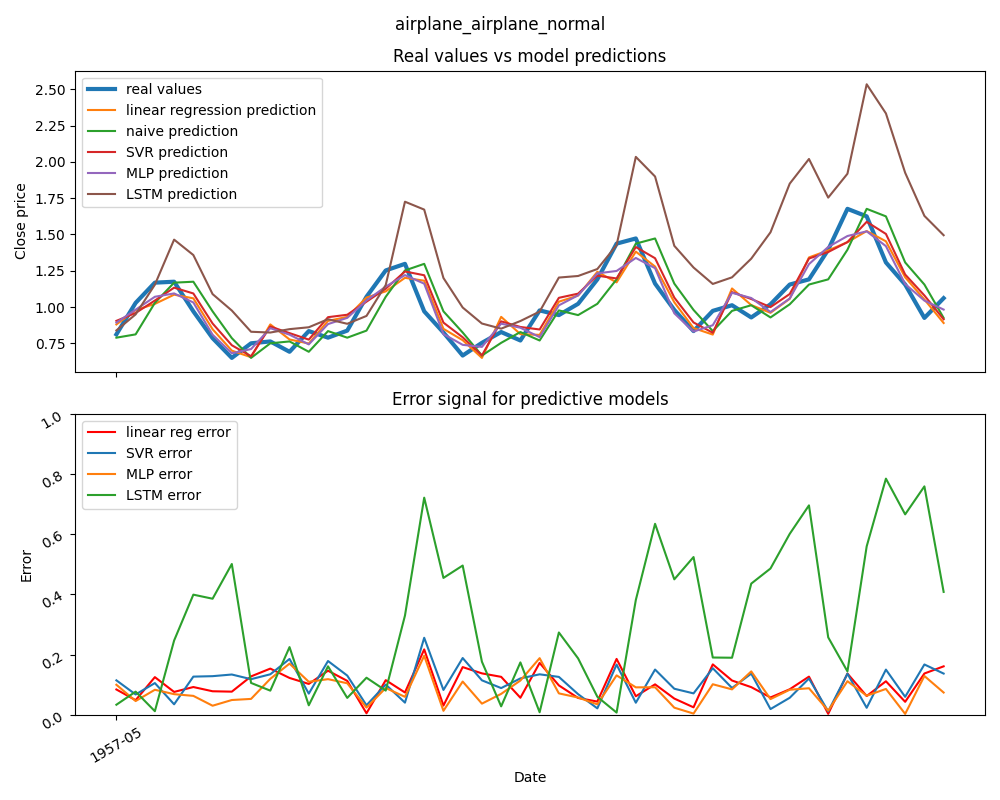

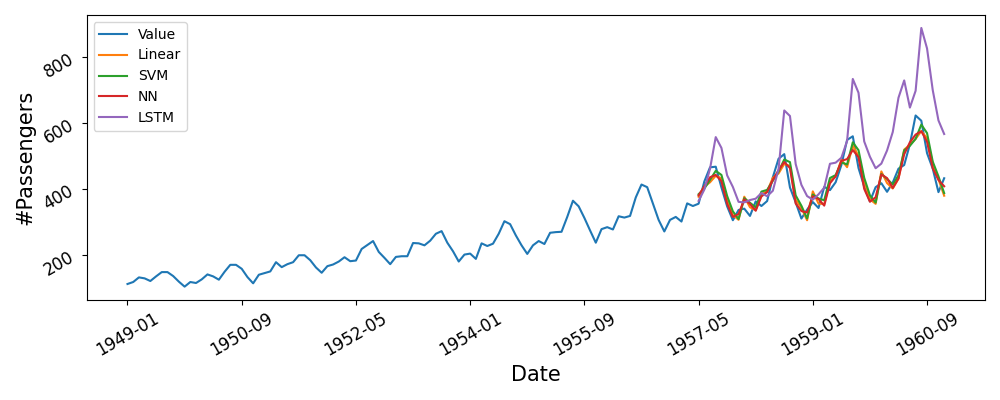

In [10]:
window_length = 15
split = 44 
column_to_predict = '#Passengers'
financial_asset = 'airplane'
feat_engineering = 'airplane_normal'

###################################################################################################
# feature engineering
###################################################################################################

denoised_signal = df['#Passengers'].to_numpy()
denoised_signal[-split:] = df['#Passengers'].iloc[-split:] # add this so we test against original data

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(denoised_signal[:-split].reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(denoised_signal[-split:].reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=False,C= 10, kernel= 'linear',epsilon=0.1)
blah.neural_net_mlp(model_tunning=False,
                    activation= 'relu', 
                    hidden_layer_sizes= (1000,), 
                    learning_rate= 'invscaling', 
                    learning_rate_init= 0.01,
                    solver='adam')
blah.lstm(model_tunning=False, n_nodes=[128,128,128], n_lstm_layers=3, n_epochs=2000, n_batch=64,verbose=1)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

###################################################################################################
# invert feature engineering (if possible)
###################################################################################################

# invert scaling
inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

# collect inverted results

df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
df_inverted_results['Date'] = df['Date']
df_inverted_results['Value'] = df[f'{column_to_predict}']
df_inverted_results['Linear'].iloc[-split:] = inverted_predictions_linear.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['SVM'].iloc[-split:] = inverted_predictions_svm.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['NN'].iloc[-split:] =  inverted_predictions_nn.flatten()#['invert_pred_value'].astype(float)
df_inverted_results['LSTM'].iloc[-split:] = inverted_predictions_lstm.flatten()#['invert_pred_value'].astype(float)

# plot invert results
ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
ax.set_xlabel(xlabel='Date',fontsize=15)
ax.tick_params(rotation=30, labelsize=12)    
plt.tight_layout()
plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

# store results
inverted_conclusion(dates=df['Date'].iloc[-split:],
                    original_values=df[f'{column_to_predict}'].iloc[-split:], 
                    linear_preds=inverted_predictions_linear, 
                    svm_pred=inverted_predictions_svm, 
                    nn_preds=inverted_predictions_nn, 
                    lstm_preds=inverted_predictions_lstm,
                    financial_asset=financial_asset,
                    feat_engineer=feat_engineering)

# airplane forecast using differencing

In [14]:
window_length = 15
split = 44 
column_to_predict = '#Passengers'
financial_asset = 'airplane'
feat_engineering = 'airplane_differenced'


###################################################################################################
# feature engineer data
###################################################################################################

df['diff'] = df[f'{column_to_predict}'].diff(periods=1)
df['diff'].iloc[0] = 0

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['diff'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['diff'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Differenced Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
blah.neural_net_mlp(model_tunning=False,
                    activation= 'relu', 
                    hidden_layer_sizes= (100, 100, 100), 
                    learning_rate= 'invscaling', 
                    learning_rate_init= 0.001,
                    solver='adam')
blah.lstm(model_tunning=True,n_batch=128)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Differenced Close price',second_plot='error')

# view final results
blah.conclusion()

###################################################################################################
# invert feature engineering (if possible)
###################################################################################################

# invert scaling
inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

# invert differencing for different models
inverted_lin = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_linear,df[f'{column_to_predict}'].iloc[-split:], df['Date'].iloc[-split:])
inverted_svm = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_svm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
inverted_nn = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_nn,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
inverted_lstm = invert_first_difference_2(df[f'{column_to_predict}'].iloc[-split],inverted_predictions_lstm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])

# collect inverted results

df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
df_inverted_results['Date'] = df['Date']
df_inverted_results['Value'] = df[f'{column_to_predict}']
df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
df_inverted_results['NN'].iloc[-split:] =  inverted_nn['invert_pred_value'].astype(float)
df_inverted_results['LSTM'].iloc[-split:] = inverted_lstm['invert_pred_value'].astype(float)

# plot invert results
ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
ax.set_xlabel(xlabel='Date',fontsize=15)
ax.tick_params(rotation=30, labelsize=12)    
plt.tight_layout()
plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

# store results
inverted_conclusion(dates=df['Date'].iloc[-split:],
                    original_values=df[f'{column_to_predict}'].iloc[-split:], 
                    linear_preds=inverted_lin['invert_pred_value'], 
                    svm_pred=inverted_svm['invert_pred_value'], 
                    nn_preds=inverted_nn['invert_pred_value'], 
                    lstm_preds=inverted_lstm['invert_pred_value'],
                    financial_asset=financial_asset,
                    feat_engineer=feat_engineering)

Trial 1 Complete [00h 00m 33s]
val_loss: 0.11386454105377197

Best val_loss So Far: 0.11386454105377197
Total elapsed time: 00h 00m 33s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
272               |112               |units 0
2                 |1                 |layers
48                |80                |units -1
0.01              |0.001             |learning_rate

Epoch 1/5
3/3 [==============================] - 7s 488ms/step - loss: 0.2450 - val_loss: 528.7490
Epoch 2/5
3/3 [==============================] - 0s 130ms/step - loss: 123.3762 - val_loss: 0.2078
Epoch 3/5
3/3 [==============================] - 0s 90ms/step - loss: 0.2487 - val_loss: 0.2360
Epoch 4/5
3/3 [==============================] - 0s 94ms/step - loss: 0.2586 - val_loss: 0.2015
Epoch 5/5
3/3 [==============================] - 0s 108ms/step - loss: 0.1861 - val_loss: 0.1053
Epoch 1/5
3/3 [==============================] - 7s 441ms/step - loss: 0.4615 - val_loss: 0.1456
Epoch 2/5

# airplane log-differencing 

In [12]:
df

Month  #Passengers  #Passengers_std  random_pertubation       noisy  \
0    1949-01          112              NaN            0.000000  112.000000   
1    1949-02          118              NaN            0.000000  118.000000   
2    1949-03          132              NaN            0.000000  132.000000   
3    1949-04          129              NaN            0.000000  129.000000   
4    1949-05          121         8.142481           -4.171398  116.828602   
..       ...          ...              ...                 ...         ...   
139  1960-08          606        74.106005         -207.663990  606.000000   
140  1960-09          508        63.998437          -30.276519  508.000000   
141  1960-10          461        67.389168          -42.103919  461.000000   
142  1960-11          390        97.840687         -113.752636  390.000000   
143  1960-12          432        82.799758          -59.813624  432.000000   

        Date  denoised_signal  diff  
0    1949-01       112.000000   0.0  
1    1949-02       118.000000   6.0  
2    1949-03       132.000000  14.0  
3    1949-04       129.000000  -3.0  
4    1949-05       116.828602  -8.0  
..       ...              ...   ...  
139  1960-08       606.000000 -16.0  
140  1960-09       508.000000 -98.0  
141  1960-10       461.000000 -47.0  
142  1960-11       390.000000 -71.0  
143  1960-12       432.000000  42.0  

[144 rows x 8 columns]

/tmp/ipykernel_34408/559352656.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_diff'].iloc[0] = 0


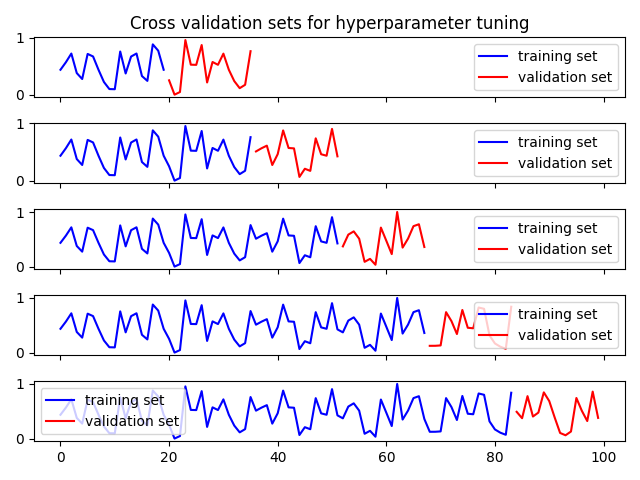

Training multivariate linear regression:

Linear regression coefficients: 
 [-0.59242938 -0.30255273 -0.67771421 -0.3051855  -0.44651704 -0.3726133
 -0.63636899 -0.24937354 -0.53703204 -0.24818299]
MAPE: 1.569832391958839
RMSE:  0.1496364077261853
MAE:  0.11581351588895078

Training support vector machine:
Model params:  {'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 2.228014220716555
RMSE:  0.2074198334784449
MAE:  0.15971821660666974

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1,

/tmp/ipykernel_34408/559352656.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/559352656.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
/tmp/ipykernel_34408/559352656.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

Movement prediction accuracy: 84.09 %
Confusion matrix:
[[15  4]
 [ 3 22]]
Movement prediction accuracy: 81.82 %
Confusion matrix:
[[16  3]
 [ 5 20]]
Movement prediction accuracy: 93.18 %
Confusion matrix:
[[19  0]
 [ 3 22]]
Movement prediction accuracy: 86.36 %
Confusion matrix:
[[15  4]
 [ 2 23]]
+----+-------------------+---------+----------+----------+----------+
|    | model             |    RMSE |      MAE |     MAPE |       DA |
|----+-------------------+---------+----------+----------+----------|
|  0 | Linear Regression | 380.351 | 319.439  | 0.731038 | 0.840909 |
|  1 | SVM               |  55.163 |  46.3941 | 0.118819 | 0.818182 |
|  2 | MLP               | 114.869 |  96.9009 | 0.22237  | 0.931818 |
|  3 | LSTM              | 651.339 | 515.881  | 1.15588  | 0.863636 |
+----+-------------------+---------+----------+----------+----------+


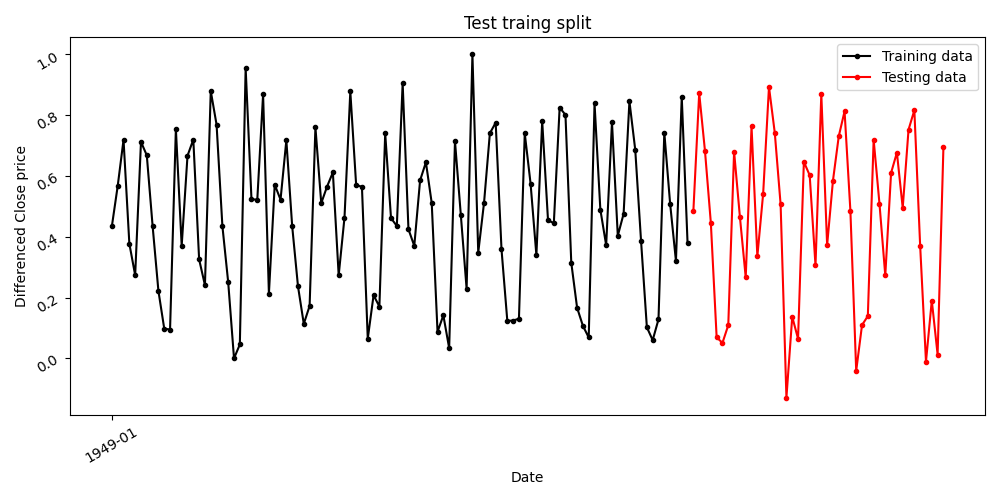

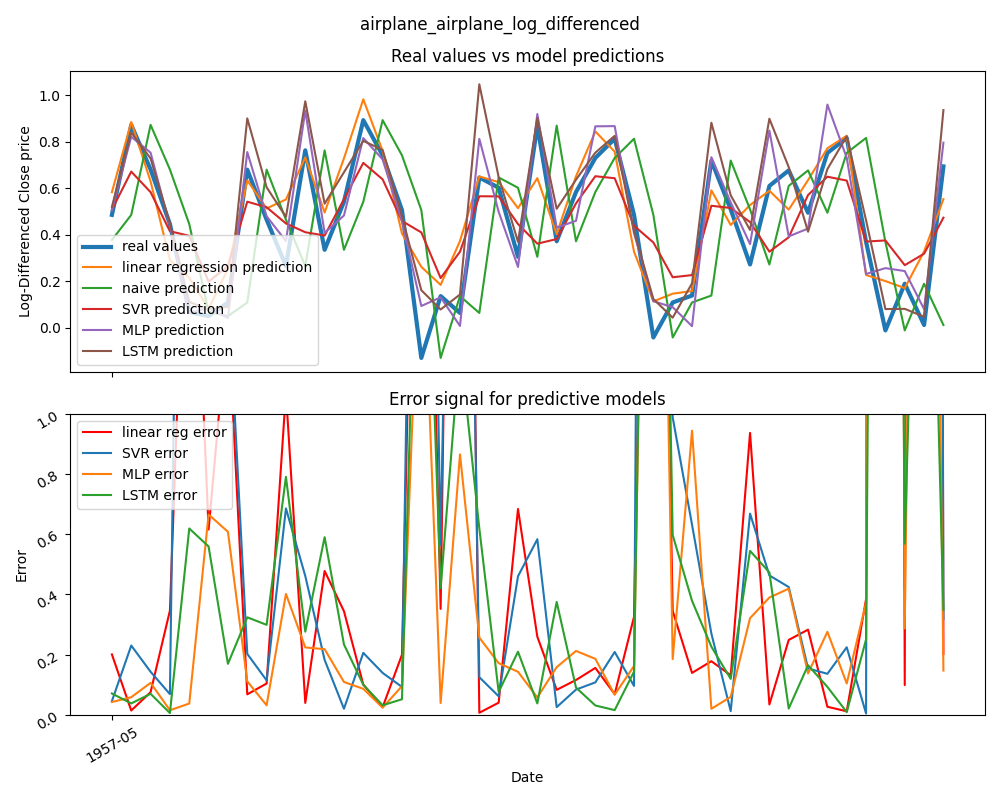

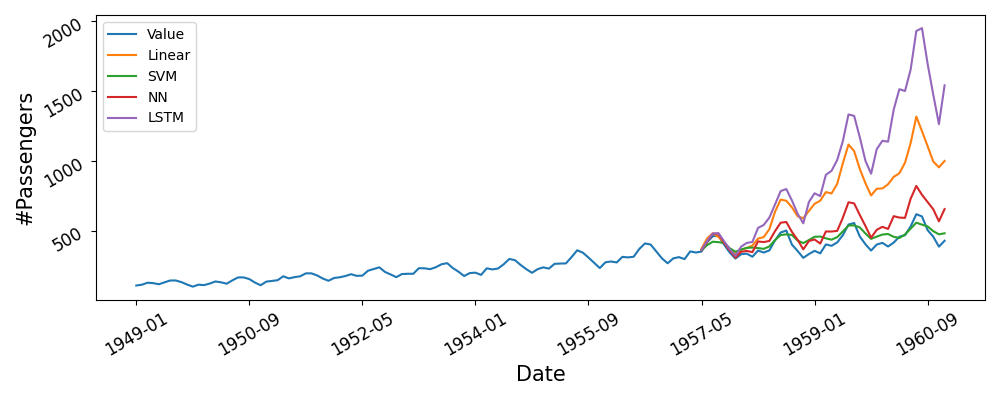

In [ ]:
window_length = 15
split = 44 
column_to_predict = '#Passengers'
financial_asset = 'airplane'
feat_engineering = 'airplane_log_differenced'


###################################################################################################
# feature engineer data
###################################################################################################
df['log'] = df[f'{column_to_predict}'].apply(lambda x: np.log(x))
df['log_diff'] = df['log'].diff(periods=1)
df['log_diff'].iloc[0] = 0

###################################################################################################
# single out of sample validation results
###################################################################################################

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['log_diff'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['log_diff'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Differenced Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=False,C= 0.1, kernel= 'linear',epsilon=0.1)
blah.neural_net_mlp(model_tunning=False,
                    activation= 'relu', 
                    hidden_layer_sizes= (100, 100, 100), 
                    learning_rate= 'invscaling', 
                    learning_rate_init= 0.001,
                    solver='adam')
blah.lstm(model_tunning=False,n_batch=12)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Log-Differenced Close price',second_plot='error')

# view final results
blah.conclusion()

###################################################################################################
# invert feature engineering (if possible)
###################################################################################################

# invert scaling
inverted_predictions_linear, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.linear_reg_predictions)
inverted_predictions_svm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.svm_predictions)
inverted_predictions_nn, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.neural_net_predictions)
inverted_predictions_lstm, inverted_testing_data = invert_scaling(scaler,scaled_input_data[-split:],blah.lstm_predictions)

# invert differencing for different models
inverted_lin = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_linear,df[f'{column_to_predict}'].iloc[-split:], df['Date'].iloc[-split:])
inverted_svm = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_svm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
inverted_nn = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_nn,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])
inverted_lstm = invert_first_difference_with_log_2(df[f'log'].iloc[-split],inverted_predictions_lstm,df[f'{column_to_predict}'].iloc[-split:],df['Date'].iloc[-split:])

# collect inverted results

df_inverted_results = pd.DataFrame(columns=['Date','Value','Linear','SVM','NN','LSTM'])
df_inverted_results['Date'] = df['Date']
df_inverted_results['Value'] = df[f'{column_to_predict}']
df_inverted_results['Linear'].iloc[-split:] = inverted_lin['invert_pred_value'].astype(float)
df_inverted_results['SVM'].iloc[-split:] = inverted_svm['invert_pred_value'].astype(float)
df_inverted_results['NN'].iloc[-split:] =  inverted_nn['invert_pred_value'].astype(float)
df_inverted_results['LSTM'].iloc[-split:] = inverted_lstm['invert_pred_value'].astype(float)

# plot invert results
ax = df_inverted_results.plot(figsize=(10,4), x='Date', fontsize=15)
ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
ax.set_xlabel(xlabel='Date',fontsize=15)
ax.tick_params(rotation=30, labelsize=12)    
plt.tight_layout()
plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_inverted.png')

# store results
inverted_conclusion(dates=df['Date'].iloc[-split:],
                    original_values=df[f'{column_to_predict}'].iloc[-split:], 
                    linear_preds=inverted_lin['invert_pred_value'], 
                    svm_pred=inverted_svm['invert_pred_value'], 
                    nn_preds=inverted_nn['invert_pred_value'], 
                    lstm_preds=inverted_lstm['invert_pred_value'],
                    financial_asset=financial_asset,
                    feat_engineer=feat_engineering)